In [1]:
#%matplotlib inline
%matplotlib notebook
%load_ext autoreload
%autoreload 2
from __future__ import unicode_literals
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font',family='serif')
#import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import CoolProp
from ammonia_props import AmmoniaProps, massFractionToMolar
import tabulate

In [2]:
throwaway = CoolProp.AbstractState("REFPROP","water")

In [3]:
# Patek and Klomfar, my implementation
# TODO

# Ibrahim and Klein, 1995
myammonia = AmmoniaProps()
def wraph(**kwargs):
    try:
        return 1000*myammonia.h(**kwargs)
    except:
        return np.nan
hfun1 = np.vectorize(wraph)

# Tillner-Roth, 1998 
#amm = lambda(x):'REFPROP::water[{}]&ammonia[{}]'.format(1-x,x)
CPRP = CoolProp.AbstractState("REFPROP","water&ammonia")

def hsat(T,Q,w,update=True):
    #h = CP.PropsSI('H','T',T,'Q',Q,amm(x))
    if update:
        x = massFractionToMolar(w)
        CPRP.set_mole_fractions([1-x,x])
    try:
        CPRP.update(CoolProp.QT_INPUTS,Q,T)
        return CPRP.hmass()
    except:
        return np.nan
hsatv = np.vectorize(hsat)


In [4]:
T_ref = 273.15
h_amm_ref_rp = CoolProp.CoolProp.PropsSI("H","T",T_ref,"Q",0,"REFPROP::ammonia")
h_amm_ref_ees = wraph(T=T_ref,x=1,Qu=0)
h_offset_amm = h_amm_ref_rp - h_amm_ref_ees
print("{}\n-  {}\n=======\n{}".format(h_amm_ref_rp, h_amm_ref_ees, h_offset_amm))

343154.63497376675
-  9.749616745638464
343144.8853570211


In [5]:
help(AmmoniaProps)

Help on class AmmoniaProps in module ammonia_props:

class AmmoniaProps(builtins.object)
 |  Imports the EES NH3H2O library, if installed.
 |  
 |  Methods defined here:
 |  
 |  P(self, **kwargs)
 |  
 |  Qu(self, **kwargs)
 |  
 |  T(self, **kwargs)
 |  
 |  __init__(self, path='C:\\EES32\\Userlib\\EES_System\\nh3h2o.dlp')
 |      Args
 |      ----
 |          path : (string)
 |              The full path to the DLL file to load.
 |  
 |  equilibriumStates(self, P, z)
 |  
 |  equilibriumStates2(self, P, z_vapor)
 |  
 |  h(self, **kwargs)
 |  
 |  props(self, code)
 |      Returns an instance of ammoniaWaterFunc instance for the given set
 |      of input parameters. The resulting object can be called as a functor.
 |      
 |      Args
 |      ----
 |          code : (string or number)
 |              Defines the three input parameters.
 |              Can be one of the numbers in availableCodes, or a string
 |              concatenation of the corresponding names.
 |  
 |  props2(

<IPython.core.display.Javascript object>


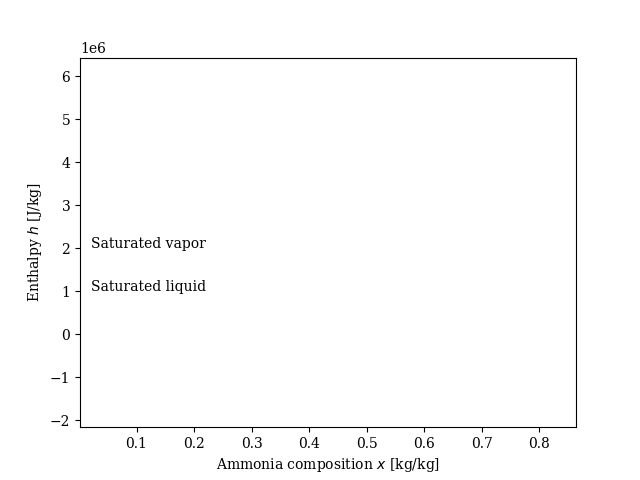

<IPython.core.display.Javascript object>


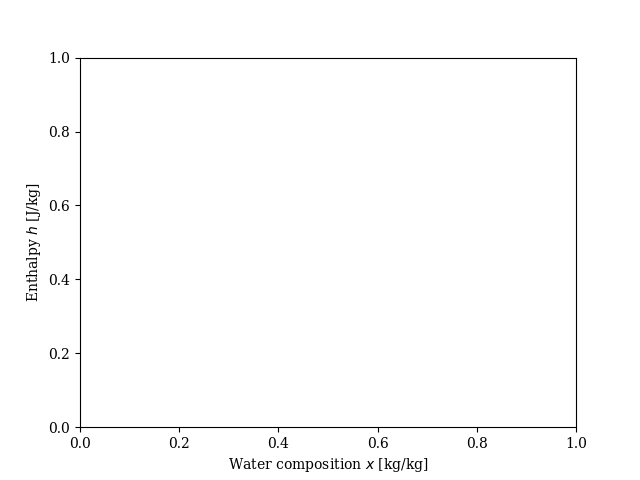

273.15
333.15
393.15
453.15
513.15


C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\numpy\lib\function_base.py:2810: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)
C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\numpy\lib\function_base.py:2810: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


573.15


In [9]:
x_w = np.logspace(-4,0)
x = 1-x_w
h_offset = x * h_offset_amm

fig1 = plt.figure(1)
plt.gca().ticklabel_format(axis='y', style = 'sci', scilimits=(-2,2), useOffset=False)
plt.xlabel('Ammonia composition $x$ [kg/kg]')
plt.ylabel('Enthalpy $h$ [J/kg]')
plt.annotate('Saturated vapor',[0.02,2e6])
plt.annotate('Saturated liquid',[0.02,1e6])
fig2 = plt.figure(2)
plt.gca().ticklabel_format(axis='y', style = 'sci', scilimits=(-2,2), useOffset=False)
plt.xlabel('Water composition $x$ [kg/kg]')
plt.ylabel('Enthalpy $h$ [J/kg]')
first = True
cc = 'b g r c m y'.split()
TT = np.linspace(273.15,573.15,6)
ees_hl_by_x = {}
ees_hv_by_x = {}
rp_hl_by_x = {}
rp_hv_by_x = {}
for T,c in zip(TT,cc):
#for T in [373]:
    print(T)
    ees_hl_by_x[T] = hfun1(T=T,Qu=0,x=x) + h_offset
    ees_hv_by_x[T] = hfun1(T=T,Qu=1,x=x) + h_offset
    rp_hl_by_x[T] = hsatv(T,0,x)
    rp_hv_by_x[T] = hsatv(T,1,x)
plt.show()

<IPython.core.display.Javascript object>


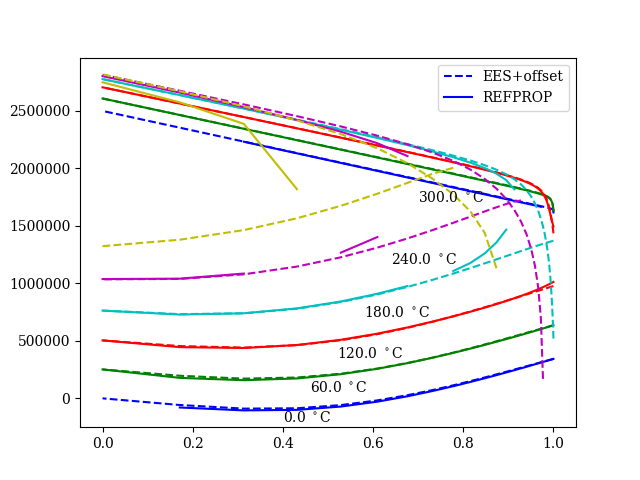

<IPython.core.display.Javascript object>


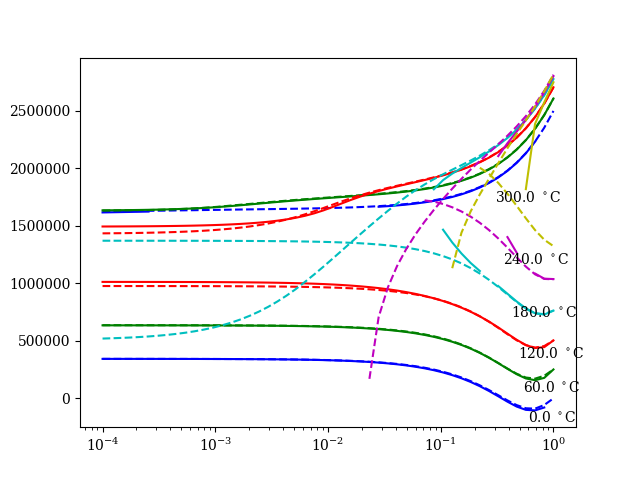

In [10]:
for T,c in zip(TT,cc):
#for T in [373]:
    plt.figure(1)
    plt.plot(x,ees_hl_by_x[T],'--',color=c,label="EES+offset" if first else None)
    plt.plot(x,ees_hv_by_x[T],'--',color=c)
    plt.plot(x,rp_hl_by_x[T],'-' ,color=c,label="REFPROP" if first else None)
    plt.plot(x,rp_hv_by_x[T],'-' ,color=c)
    xtext = 0.4 + (T-273.15) * 0.001
    htext = hfun1(T=T+5,Qu=0,x=xtext)
    plt.annotate('{} $^\circ$C'.format(T-273.15),[xtext,htext])
    plt.figure(2)
    plt.semilogx(x_w,ees_hl_by_x[T],'--',color=c)
    plt.semilogx(x_w,ees_hv_by_x[T],'--',color=c)
    plt.semilogx(x_w,rp_hl_by_x[T],'-' ,color=c)
    plt.semilogx(x_w,rp_hv_by_x[T],'-' ,color=c)
    plt.annotate('{} $^\circ$C'.format(T-273.15),[1-xtext,htext])
    first = False
plt.figure(1)
plt.legend(loc='best')
plt.show()

In [12]:
# Saturation curve of pure ammonia, because REFPROP is not good near there
rp_amm = CoolProp.AbstractState("HEOS","ammonia")
rp_amm.build_phase_envelope("")
def h_amm_rp(T,Q):
    try:
        rp_amm.update(CoolProp.QT_INPUTS,Q,T)
        return rp_amm.hmass()
    except:
        return np.nan
hamham = np.vectorize(h_amm_rp)
# Pure water, same
rp_water = CoolProp.AbstractState("HEOS","water")
rp_water.build_phase_envelope("")
def h_water_rp(T,Q):
    try:
        rp_water.update(CoolProp.QT_INPUTS,Q,T)
        return rp_water.hmass()
    except:
        return np.nan
humhum = np.vectorize(h_water_rp)

T_c = {}
P_c = {}
h_c = {}
T_c[1] = rp_amm.T_critical()
P_c[1] = rp_amm.p_critical()
rp_amm.specify_phase(CoolProp.iphase_critical_point)
rp_amm.update(CoolProp.PT_INPUTS,P_c[1],T_c[1])
h_c[1] = rp_amm.hmass()
rp_amm.specify_phase(CoolProp.iphase_unknown)
T_c[0] = rp_water.T_critical()
P_c[0] = rp_water.p_critical()
rp_water.specify_phase(CoolProp.iphase_critical_point)
rp_water.update(CoolProp.PT_INPUTS,P_c[0],T_c[0])
h_c[0] = rp_water.hmass()
rp_water.specify_phase(CoolProp.iphase_unknown)

ees_hl_by_T = {}
ees_hv_by_T = {}
rp_hl_by_T = {}
rp_hv_by_T = {}

x = 1
Tee = np.linspace(273,T_c[1],100)
xx=x*np.ones_like(Tee)
rp_hl_by_T[x] = hamham(Tee,0)
rp_hv_by_T[x] = hamham(Tee,1)

for x in [0.2,0.4,0.6,0.8,0.9,0.99,0.999]:
    xx = x*np.ones_like(Tee)
    hsatv(300,0,x)
    T_c[x] = CPRP.T_critical()
    P_c[x] = CPRP.p_critical()
    #CPRP.specify_phase(CoolProp.constants.iphase_critical_point)
    CPRP.update(CoolProp.PT_INPUTS,P_c[x],T_c[x])
    h_c[x] = CPRP.hmass()
    #CPRP.specify_phase(CoolProp.constants.iphase_twophase)
    print("Tc_computed = {}".format(T_c[x]))
    
    Tee = np.linspace(273,T_c[x],100)
    rp_hl_by_T[x] = hsatv(Tee,0,x,False)
    rp_hv_by_T[x] = hsatv(Tee,1,x,False)
    
x = 0
Tee = np.linspace(273, T_c[0],100)
xx=x*np.ones_like(Tee)
rp_hl_by_T[x] = humhum(Tee,0)
rp_hv_by_T[x] = humhum(Tee,1)

Tc_computed = 609.5626978390263
Tc_computed = 570.2705757165487
Tc_computed = 528.292109976492
Tc_computed = 480.35507411252814
Tc_computed = 448.58079676899
Tc_computed = 410.41769899728735
Tc_computed = 405.9098922705099


In [15]:
keys = list(P_c.keys())
keys.sort()
critical_data = np.array([(k,P_c[k],T_c[k],h_c[k]) for k in keys])
print(tabulate.tabulate(critical_data,"x P T h".split()))
critical_data[:,0]

    x            P        T            h
-----  -----------  -------  -----------
0      2.2064e+07   647.096  2.0873e+06
0.2    2.10731e+07  609.563  1.99408e+06
0.4    1.94653e+07  570.271  1.84762e+06
0.6    1.80713e+07  528.292  1.68339e+06
0.8    1.67177e+07  480.355  1.5212e+06
0.9    1.49619e+07  448.581  1.41137e+06
0.99   1.18128e+07  410.418  1.28287e+06
0.999  1.13879e+07  405.91   1.26565e+06
1      1.1333e+07   405.4    1.31622e+06


array([ 0.   ,  0.2  ,  0.4  ,  0.6  ,  0.8  ,  0.9  ,  0.99 ,  0.999,  1.   ])

In [16]:
import ammonia1

In [17]:
chiller = ammonia1.AmmoniaChiller()
chiller.update()
display(chiller)
cst=chiller.stateTable()
cst['T']

,T,P,x,h,s,u,v,Qu
rich_abs_outlet,310.15,4.95842,0.516319,-73.3924,0.39369,-74.0037,0.00123283,0
rich_pump_outlet,310.312,15.007,0.516319,-71.8442,0.394689,-73.6936,0.00123237,-0.001
rich_shx_outlet,345.339,15.007,0.516319,87.9968,0.882582,86.0558,0.00129346,-0.001
rich_gen_sat_liquid,350.837,15.007,0.516319,114.086,0.957653,112.127,0.00130524,0
weak_gen_outlet,374.15,15.007,0.392795,226.277,1.26127,224.375,0.00126746,0
weak_shx_outlet,329.868,15.007,0.392795,25.6039,0.690781,23.8187,0.00118956,-0.001
weak_exp_outlet,330.038,4.95842,0.392795,25.6039,0.694405,25.0136,0.00119041,-0.001
gen_vapor_outlet,350.837,15.007,0.988783,1421.49,4.56966,1266.12,0.103531,1
gen_reflux_inlet,350.837,15.007,0.516182,113.699,0.956447,111.74,0.00130547,0
refrig_rect_outlet,313.65,15.007,0.999869,1299.17,4.20264,1168.41,0.0871322,1.001


array([ 310.1499939 ,  310.31192017,  345.33944702,  350.83746338,
        374.1499939 ,  329.86834717,  330.03833008,  350.83746338,
        350.83746338,  313.6499939 ,  311.8500061 ,  295.05761719,
        277.0614624 ,  278.45001221,  283.82223511,  310.07052612,
        313.6499939 ,  374.1499939 ,  330.03833008], dtype=float32)

<IPython.core.display.Javascript object>


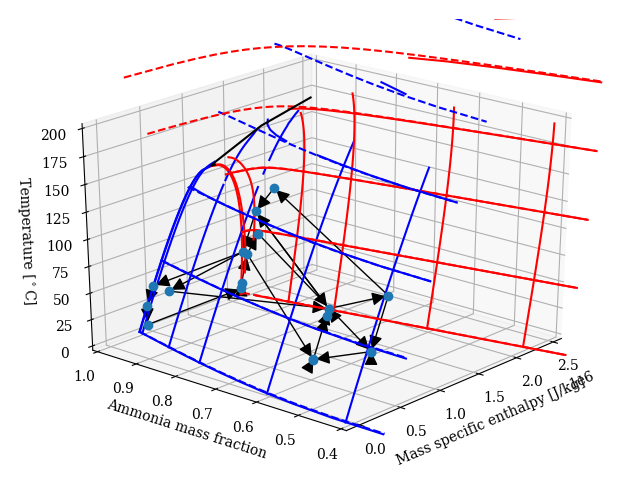

In [19]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.ticklabel_format(axis='x', style = 'sci', scilimits=(-2,2), useOffset=False)
plt.xlabel('Mass specific enthalpy [J/kg]')
plt.ylabel('Ammonia mass fraction')
ax.set_zlabel('Temperature [$^\circ$C]')

x = 1
Tee = np.linspace(273,T_c[x],100)
xx=x*np.ones_like(Tee)
plt.plot(rp_hl_by_T[x],xx,Tee-273.15,'b')
plt.plot(rp_hv_by_T[x],xx,Tee-273.15,'r')

#for x in [0.2,0.4,0.6,0.8,0.9,0.99,0.999]:
for x in [0.4,0.6,0.8,0.9,0.99,0.999]:
    Tee = np.linspace(273,T_c[x],100)
    xx = x*np.ones_like(Tee)
    indices = Tee < 273+200
    plt.plot(rp_hl_by_T[x][indices],xx[indices],Tee[indices]-273.15,'b')
    plt.plot(rp_hv_by_T[x][indices],xx[indices],Tee[indices]-273.15,'r')

x = 0
Tee = np.linspace(273, T_c[x],100)
xx=x*np.ones_like(Tee)
#plt.plot(rp_hl_by_T[x],xx,Tee-273.15,'b')
#plt.plot(rp_hv_by_T[x],xx,Tee-273.15,'r')

x_w = np.logspace(-4,0)
x = 1-x_w
#for T,c in zip(TT,cc)[:3]:
for T,c in zip(TT,cc):
#for T in [373]:
    indices = x >= 0.3
    plt.plot(ees_hl_by_x[T][indices],x[indices],T-273.15,'b--')
    plt.plot(ees_hv_by_x[T][indices],x[indices],T-273.15,'r--')
    plt.plot(rp_hl_by_x[T][indices],x[indices],T-273.15,'b-' )
    plt.plot(rp_hv_by_x[T][indices],x[indices],T-273.15,'r-' )

indices = critical_data[:,2] < 500
plt.plot(critical_data[indices,3],critical_data[indices,0],critical_data[indices,2]-273.15,
         'k')

h = cst['h']*1e3 + cst['x'] * h_offset_amm
plt.plot(h,cst['x'],cst['T']-273.15,'o')
for p,x,y,z in zip(chiller.points,h,cst['x'],cst['T']-273.15):
    #ax.text(x,y,z,  p, size=20, zorder=1, color='k') 
    pass
from Arrow3D import Arrow3D
for (i,j) in chiller.getPaths():
    #plt.plot(h[[i,j]],cst['x'][[i,j]],cst['T'][[i,j]]-273.15)
    a=Arrow3D(h[[i,j]],cst['x'][[i,j]],cst['T'][[i,j]]-273.15,mutation_scale=20, lw=1, arrowstyle="-|>", color="k")
    ax.add_artist(a)

ax.margins(0)
ax.autoscale_view('tight')
ax.view_init(20,-36)
fig.tight_layout()
plt.savefig('../img/view1.svg')
ax.view_init(20,-73)
fig.tight_layout()
plt.savefig('../img/view2.svg')
ax.view_init(20,-109)
fig.tight_layout()
plt.savefig('../img/view3.svg')
ax.set_ylim([0.4,1])
ax.set_zlim([0,200])
plt.show()

<IPython.core.display.Javascript object>


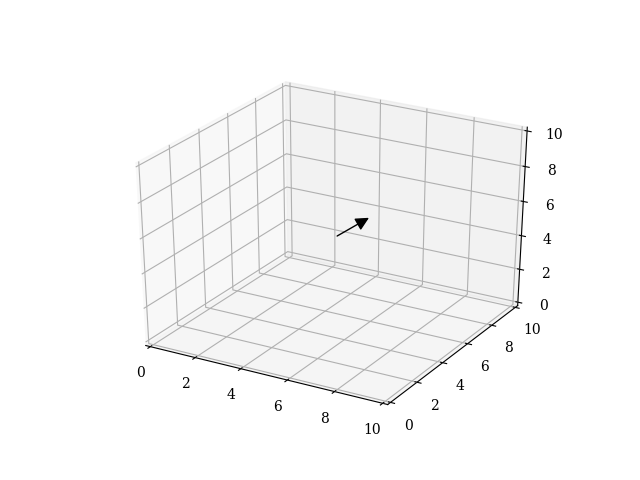

In [20]:
from Arrow3D import Arrow3D
fig = plt.figure()
ax = fig.gca(projection='3d')
#ax.quiver3D(6,6,6,1,1,1)
a=Arrow3D((5,6),(5,6),(5,6),mutation_scale=20, lw=1, arrowstyle="-|>", color="k")
ax.add_artist(a)
ax.set_xlim([0,10])
ax.set_ylim([0,10])
ax.set_zlim([0,10])
plt.show()

In [22]:
print(CoolProp.CoolProp.PropsSI("H","T",373,"Q",0,"REFPROP::ammonia"))
print(CoolProp.CoolProp.PropsSI("H","T",195.495,"Q",0,"REFPROP::ammonia[1]&water[0]"))
print(CoolProp.CoolProp.PropsSI("H","T",195.495,"Q",0,"REFPROP::ammonia"))
print(CoolProp.CoolProp.PropsSI("H","T",273.16,"Q",0,"REFPROP::ammonia[0]&water[1]"))
print(CoolProp.CoolProp.PropsSI("H","T",273.16,"Q",0,"REFPROP::water"))

863182.1717801476
8.31109023148011
8.31109023148011
-29.965477513785718
0.6117816596095991


In [23]:
CoolProp.CoolProp.set_reference_state('ammonia','DEF')
CoolProp.CoolProp.PropsSI("H","T",373,"Q",0,"HEOS::ammonia")

863182.2542360559

In [24]:
CPRP.set_mole_fractions([0.001,0.999])
CPRP.update(CoolProp.QT_INPUTS,0,373)
CPRP.mole_fractions_liquid()

[0.001, 0.999]

In [25]:
myammonia.h(T=273.15,x=1,Qu=0)

0.009749616745638465

In [28]:
print(CoolProp.CoolProp.PropsSI("H","T",273.16,"Q",0,"REFPROP::ammonia[0]&water[1]"))
print(CoolProp.CoolProp.PropsSI("H","T",273.16,"Q",0,"REFPROP::water"))

-29.965477513785718
0.6117816596095991


In [29]:
CoolProp.CoolProp.PropsSI("T","H",2e6,"Q",0,"REFPROP::ammonia[1]&water[0]")

ValueError: Input pair variable is invalid and output(s) are non-trivial; cannot do state update : PropsSI("T","H",2000000,"Q",0,"REFPROP::ammonia[1]&water[0]")

In [30]:
reload(ammonia1)

NameError: name 'reload' is not defined